# Graded Programming Assignment

In this assignment, you will implement re-use the unsupervised anomaly detection algorithm but turn it into a simpler feed forward neural network for supervised classification.

You are training the neural network from healthy and broken samples and at later stage hook it up to a message queue for real-time anomaly detection.

We've provided a skeleton for you containing all the necessary code but left out some important parts indicated with ### your code here ###

After you’ve completed the implementation please submit it to the autograder


In [1]:
!pip install tensorflow==2.2.0rc0

     |████████████████████████████████| 515.9MB 58kB/s s eta 0:00:01                        | 66.2MB 44.3MB/s eta 0:00:11     |██████▎                         | 100.6MB 43.6MB/s eta 0:00:10     |███████▏                        | 115.3MB 43.6MB/s eta 0:00:10     |███████▋                        | 122.7MB 43.6MB/s eta 0:00:10     |█████████                       | 144.7MB 13.9MB/s eta 0:00:27     |█████████▍                      | 151.9MB 13.9MB/s eta 0:00:27/s eta 0:00:06�█████████████▋             | 300.5MB 40.2MB/s eta 0:00:06MB/s eta 0:00:12��██▌           | 330.4MB 16.3MB/s eta 0:00:12     |████████████████████▉           | 336.3MB 16.3MB/s eta 0:00:11��██████████████████████         | 370.0MB 4.4MB/s eta 0:00:345.7MB 55.1MB/s eta 0:00:03�███████████▉       | 400.8MB 55.1MB/s eta 0:00:03     |███████████████████████████▏    | 437.7MB 10.1MB/s eta 0:00:08     |███████████████████████████▌    | 442.9MB 10.1MB/s eta 0:00:08██████████████████▎  | 471.9MB 5.6MB/s eta 0:00:08█████████████

     |████████████████████████████████| 163kB 43.5MB/s eta 0:00:01
     |████████████████████████████████| 153kB 43.5MB/s eta 0:00:01
     |████████████████████████████████| 81kB 28.4MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
ERROR: tensorboard 2.1.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.16.1 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninstalling Keras-Preprocessing-1.0.5:
      Successfully uninstalled Keras-Preprocessing-1.0.5
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Fo

In [2]:
import tensorflow as tf
if not tf.__version__ == '2.2.0-rc0':
    print(tf.__version__)
    raise ValueError('please upgrade to TensorFlow 2.2.0-rc0, or restart your Kernel (Kernel->Restart & Clear Output)')

Now we import all the dependencies 

In [3]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from queue import Queue
import pandas as pd
import json
%matplotlib inline

We grab the files necessary for taining. Those are sampled from the lorenz attractor model implemented in NodeRED. Those are two serialized pickle numpy arrays. In case you are interested in how these data has been generated please have a look at the following tutorial. https://developer.ibm.com/tutorials/iot-deep-learning-anomaly-detection-2/

In [4]:
!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
!mv watsoniotp.healthy.phase_aligned.pickle watsoniotp.healthy.pickle
!mv watsoniotp.broken.phase_aligned.pickle watsoniotp.broken.pickle

rm: cannot remove ‘watsoniotp.*’: No such file or directory
--2020-08-01 11:11:07--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: ‘watsoniotp.healthy.phase_aligned.pickle’

100%[======================================>] 194,639     --.-K/s   in 0.009s  

2020-08-01 11:11:07 (20.7 MB/s) - ‘watsoniotp.healthy.phase_aligned.pickle’ saved [194639/194639]

--2020-08-01 11:11:09--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercont

De-serialize the numpy array containing the training data

In [5]:
data_healthy = pickle.load(open('watsoniotp.healthy.pickle', 'rb'), encoding='latin1')
data_broken = pickle.load(open('watsoniotp.broken.pickle', 'rb'), encoding='latin1')

Reshape to three columns and 3000 rows. In other words three vibration sensor axes and 3000 samples

Since this data is sampled from the Lorenz Attractor Model, let's plot it with a phase lot to get the typical 2-eyed plot. First for the healthy data

Text(0.5, 0.92, 'Lorenz Attractor')

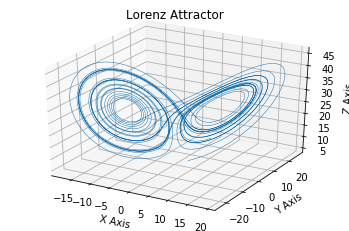

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(data_healthy[:,0], data_healthy[:,1], data_healthy[:,2],lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

Then for the broken one

Text(0.5, 0.92, 'Lorenz Attractor')

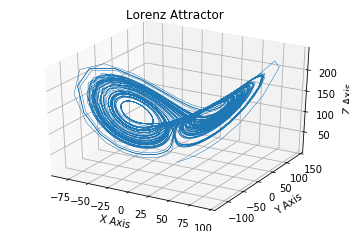

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(data_broken[:,0], data_broken[:,1], data_broken[:,2],lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

In the previous examples, we fed the raw data into an LSTM. Now we want to use an ordinary feed-forward network. So we need to do some pre-processing of this time series data

A widely-used method in traditional data science and signal processing is called Discrete Fourier Transformation. This algorithm transforms from the time to the frequency domain, or in other words, it returns the frequency spectrum of the signals.

The most widely used implementation of the transformation is called FFT, which stands for Fast Fourier Transformation, let’s run it and see what it returns


In [8]:
data_healthy_fft = np.fft.fft(data_healthy).real
data_broken_fft = np.fft.fft(data_broken).real

Let’s first have a look at the shape and contents of the arrays.

In [9]:
print (data_healthy_fft.shape)
print (data_healthy_fft)

(3000, 3)
[[ 9.42619266 -1.59309633 -1.59309633]
 [ 9.9036992  -1.6764064  -1.6764064 ]
 [10.43779318 -1.75331404 -1.75331404]
 ...
 [24.9690127  -5.47609496 -5.47609496]
 [25.97317526 -5.51210266 -5.51210266]
 [27.08054148 -5.56743205 -5.56743205]]


First, we notice that the shape is the same as the input data. So if we have 3000 samples, we get back 3000 spectrum values, or in other words 3000 frequency bands with the intensities.

The second thing we notice is that the data type of the array entries is not float anymore, it is complex. So those are not complex numbers, it is just a means for the algorithm the return two different frequency compositions in one go. The real part returns a sine decomposition and the imaginary part a cosine. We will ignore the cosine part in this example since it turns out that the sine part already gives us enough information to implement a good classifier.

But first let’s plot the two arrays to get an idea how a healthy and broken frequency spectrum differ


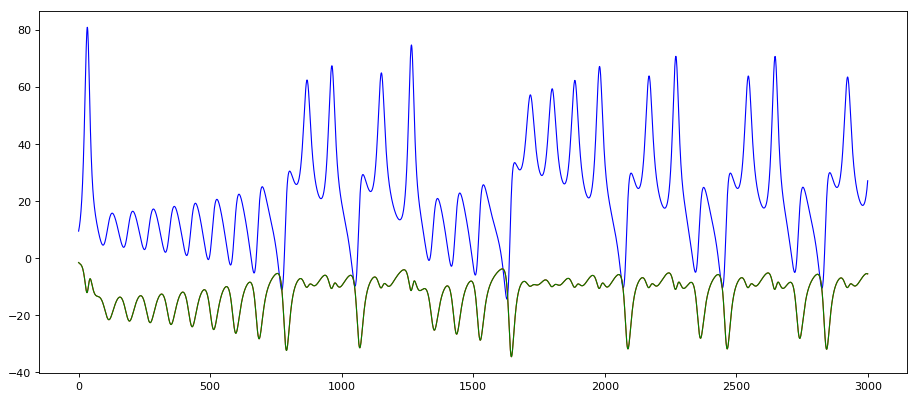

In [10]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1].real, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

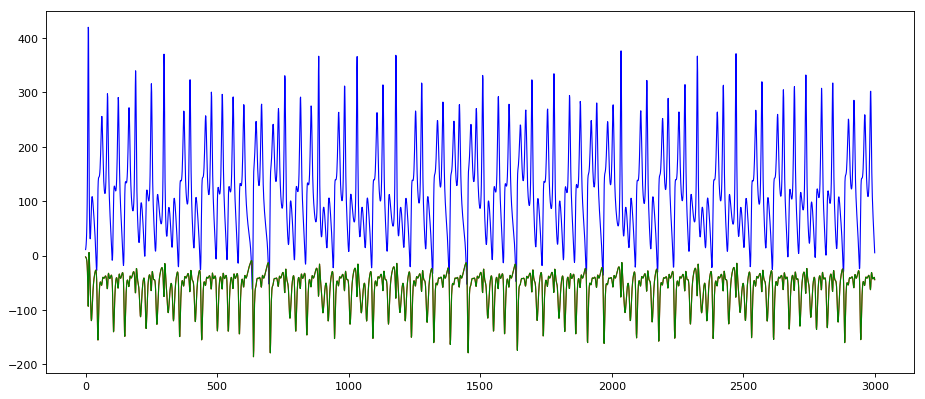

In [11]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1].real, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

So, what we've been doing is so called feature transformation step. We’ve transformed the data set in a way that our machine learning algorithm – a deep feed forward neural network implemented as binary classifier – works better. So now let's scale the data to a 0..1

In [12]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

And please don’t worry about the warnings. As explained before we don’t need the imaginary part of the FFT

In [13]:
data_healthy_scaled = scaleData(data_healthy_fft)
data_broken_scaled = scaleData(data_broken_fft)

In [14]:
data_healthy_scaled = data_healthy_scaled.T
data_broken_scaled = data_broken_scaled.T

Now we reshape again to have three examples (rows) and 3000 features (columns). It's important that you understand this. We have turned our initial data set which containd 3 columns (dimensions) of 3000 samples. Since we applied FFT on each column we've obtained 3000 spectrum values for each of the 3 three columns. We are now using each column with the 3000 spectrum values as one row (training example) and each of the 3000 spectrum values becomes a column (or feature) in the training data set

In [15]:
data_healthy_scaled.reshape(3, 3000)
data_broken_scaled.reshape(3, 3000)

array([[0.15198831, 0.15926736, 0.1705979 , ..., 0.18128196, 0.15906354,
        0.13972883],
       [0.95790869, 0.95431429, 0.94972119, ..., 0.76231153, 0.75661709,
        0.73956562],
       [0.95790869, 0.95431429, 0.94972119, ..., 0.76231153, 0.75661709,
        0.73956562]])

# Start of Assignment

The first thing we need to do is to install a little helper library for submitting the solutions to the coursera grader:

In [16]:
!rm -f rklib.py
!wget https://raw.githubusercontent.com/IBM/coursera/master/rklib.py

--2020-08-01 11:17:40--  https://raw.githubusercontent.com/IBM/coursera/master/rklib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2540 (2.5K) [text/plain]
Saving to: ‘rklib.py’

100%[======================================>] 2,540       --.-K/s   in 0s      

2020-08-01 11:17:40 (31.7 MB/s) - ‘rklib.py’ saved [2540/2540]



Please specify you email address you are using with cousera here:

In [17]:
from rklib import submit, submitAll
key = "4vkB9vnrEee8zg4u9l99rA"
all_parts = ["O5cR9","0dXlH","ZzEP8"]

email = "kriwohizha@gmail.com"


## Task

Given, the explanation above, please fill in the following two constants in order to make the neural network work properly

In [23]:
dim = 3000
samples = 3

### Submission

Now it’s time to submit your first solution. Please make sure that the secret variable contains a valid submission token. You can obtain it from the courser web page of the course using the grader section of this assignment.


In [24]:
part = "O5cR9"
token = "6vemRNPHrQlvWbBo"
parts_data = {}
parts_data["0dXlH"] = json.dumps({"number_of_neurons_layer1": 0, "number_of_neurons_layer2": 0, "number_of_neurons_layer3": 0, "number_of_epochs": 0})
parts_data["O5cR9"] = json.dumps({"dim": dim, "samples": samples})
parts_data["ZzEP8"] = None 


submitAll(email, token, key, parts_data)

Submission successful, please check on the coursera grader page for the status
-------------------------
{"elements":[{"itemId":"MsJRK","id":"tE4j0qhMEeecqgpT6QjMdA~MsJRK~Yf9AGdPpEeqDPwr5XqwvkQ","courseId":"tE4j0qhMEeecqgpT6QjMdA"}],"paging":{},"linked":{}}
-------------------------


To observe how training works we just print the loss during training

In [25]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr = LossHistory()

## Task

Please fill in the following constants to properly configure the neural network. For some of them you have to find out the precise value, for others you can try and see how the neural network is performing at a later stage. The grader only looks at the values which need to be precise


In [46]:
number_of_neurons_layer1 = 3000
number_of_neurons_layer2 = 256
number_of_neurons_layer3 = 1
number_of_epochs = 50

### Submission

Please submit your constants to the grader

In [47]:
parts_data = {}
parts_data["0dXlH"] = json.dumps({"number_of_neurons_layer1": number_of_neurons_layer1, "number_of_neurons_layer2": number_of_neurons_layer2, "number_of_neurons_layer3": number_of_neurons_layer3, "number_of_epochs": number_of_epochs})
parts_data["O5cR9"] = json.dumps({"dim": dim, "samples": samples})
parts_data["ZzEP8"] = None 
                                 
                                 
token = "6vemRNPHrQlvWbBo"


submitAll(email, token, key, parts_data)

Submission successful, please check on the coursera grader page for the status
-------------------------
{"elements":[{"itemId":"MsJRK","id":"tE4j0qhMEeecqgpT6QjMdA~MsJRK~sKHnwNPqEeqexhLGOR_gOQ","courseId":"tE4j0qhMEeecqgpT6QjMdA"}],"paging":{},"linked":{}}
-------------------------


## Task

Now it’s time to create the model. Please fill in the placeholders. Please note since this is only a toy example, we don't use a separate corpus for training and testing. Just use the same data for fitting and scoring


In [48]:
# design network
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)

model = Sequential()
model.add(Dense(number_of_neurons_layer1,input_shape=(dim, ), activation='relu'))
model.add(Dense(number_of_neurons_layer2, activation='relu'))
model.add(Dense(number_of_neurons_layer3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd)

def train(data,label):
    model.fit(data, label, epochs=number_of_epochs, batch_size=72, validation_data=(data, label), verbose=0, shuffle=True, callbacks=[lr])

def score(data):
    return model.predict(data)

We prepare the training data by concatenating a label “0” for the broken and a label “1” for the healthy data. Finally we union the two data sets together

In [49]:
label_healthy = np.repeat(1,3)
label_healthy.shape = (3,1)
label_broken = np.repeat(0,3)
label_broken.shape = (3,1)

train_healthy = np.hstack((data_healthy_scaled,label_healthy))
train_broken = np.hstack((data_broken_scaled,label_broken))
train_both = np.vstack((train_healthy,train_broken))

Let’s have a look at the two training sets for broken and healthy and at the union of them. Note that the last column is the label

In [50]:
pd.DataFrame(train_healthy)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.250133,0.255146,0.260753,0.267016,0.274003,0.281791,0.290462,0.300109,0.310834,0.322747,...,0.369150,0.374541,0.380644,0.387513,0.395205,0.403782,0.413308,0.423850,0.435476,1.0
1,1.000000,0.997476,0.995146,0.992915,0.990694,0.988398,0.985940,0.983234,0.980193,0.976722,...,0.879227,0.880696,0.881835,0.882609,0.882982,0.882912,0.882356,0.881265,0.879589,1.0
2,1.000000,0.997476,0.995146,0.992915,0.990694,0.988398,0.985940,0.983234,0.980193,0.976722,...,0.879227,0.880696,0.881835,0.882609,0.882982,0.882912,0.882356,0.881265,0.879589,1.0


In [51]:
pd.DataFrame(train_broken)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.151988,0.159267,0.170598,0.188207,0.215687,0.25888,0.327175,0.434534,0.596514,0.810387,...,0.322272,0.295635,0.271778,0.249154,0.226781,0.204146,0.181282,0.159064,0.139729,0.0
1,0.957909,0.954314,0.949721,0.942610,0.930689,0.91001,0.873657,0.810554,0.708197,0.572845,...,0.752342,0.747264,0.747707,0.751641,0.756913,0.761310,0.762312,0.756617,0.739566,0.0
2,0.957909,0.954314,0.949721,0.942610,0.930689,0.91001,0.873657,0.810554,0.708197,0.572845,...,0.752342,0.747264,0.747707,0.751641,0.756913,0.761310,0.762312,0.756617,0.739566,0.0


In [52]:
pd.DataFrame(train_both)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.250133,0.255146,0.260753,0.267016,0.274003,0.281791,0.290462,0.300109,0.310834,0.322747,...,0.369150,0.374541,0.380644,0.387513,0.395205,0.403782,0.413308,0.423850,0.435476,1.0
1,1.000000,0.997476,0.995146,0.992915,0.990694,0.988398,0.985940,0.983234,0.980193,0.976722,...,0.879227,0.880696,0.881835,0.882609,0.882982,0.882912,0.882356,0.881265,0.879589,1.0
2,1.000000,0.997476,0.995146,0.992915,0.990694,0.988398,0.985940,0.983234,0.980193,0.976722,...,0.879227,0.880696,0.881835,0.882609,0.882982,0.882912,0.882356,0.881265,0.879589,1.0
3,0.151988,0.159267,0.170598,0.188207,0.215687,0.258880,0.327175,0.434534,0.596514,0.810387,...,0.322272,0.295635,0.271778,0.249154,0.226781,0.204146,0.181282,0.159064,0.139729,0.0
4,0.957909,0.954314,0.949721,0.942610,0.930689,0.910010,0.873657,0.810554,0.708197,0.572845,...,0.752342,0.747264,0.747707,0.751641,0.756913,0.761310,0.762312,0.756617,0.739566,0.0
5,0.957909,0.954314,0.949721,0.942610,0.930689,0.910010,0.873657,0.810554,0.708197,0.572845,...,0.752342,0.747264,0.747707,0.751641,0.756913,0.761310,0.762312,0.756617,0.739566,0.0


So those are frequency bands. Notice that although many frequency bands are having nearly the same energy, the neural network algorithm still can work those out which are significantly different. 

## Task

Now it’s time to do the training. Please provide the first 3000 columns of the array as the 1st parameter and column number 3000 containing the label as 2nd parameter. Please use the python array slicing syntax to obtain those. 

The following link tells you more about the numpy array slicing syntax
https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html


In [53]:
features = train_both[:,:-1]
labels = train_both[:,-1]

Now it’s time to do the training. You should see the loss trajectory go down, we will also plot it later. Note: We also could use TensorBoard for this but for this simple scenario we skip it. In some rare cases training doesn’t converge simply because random initialization of the weights caused gradient descent to start at a sub-optimal spot on the cost hyperplane. Just recreate the model (the cell which contains *model = Sequential()*) and re-run all subsequent steps and train again



In [54]:
train(features,labels)

0.697406530380249, 0.6228913068771362, 0.5600300431251526, 0.507082998752594, 0.4639233648777008, 0.4228990077972412, 0.3868755102157593, 0.35415515303611755, 0.32883521914482117, 0.30773547291755676, 0.28533628582954407, 0.26749396324157715, 0.24964672327041626, 0.23372645676136017, 0.21875645220279694, 0.2047019600868225, 0.19312475621700287, 0.18212862312793732, 0.17054383456707, 0.16078047454357147, 0.15084350109100342, 0.14139413833618164, 0.1330304890871048, 0.12530404329299927, 0.11800401657819748, 0.11158943921327591, 0.10501817613840103, 0.09924518316984177, 0.093429334461689, 0.08816958218812943, 0.08342113345861435, 0.07913864403963089, 0.07515926659107208, 0.07176172733306885, 0.06867285072803497, 0.06577272713184357, 0.06315256655216217, 0.060663361102342606, 0.05844882130622864, 0.05630422756075859, 0.0543389618396759, 0.052490025758743286, 0.05071764811873436, 0.04909747838973999, 0.04757587984204292, 0.046116903424263, 0.0447147898375988, 0.04341855272650719, 0.04218988

Let's plot the losses

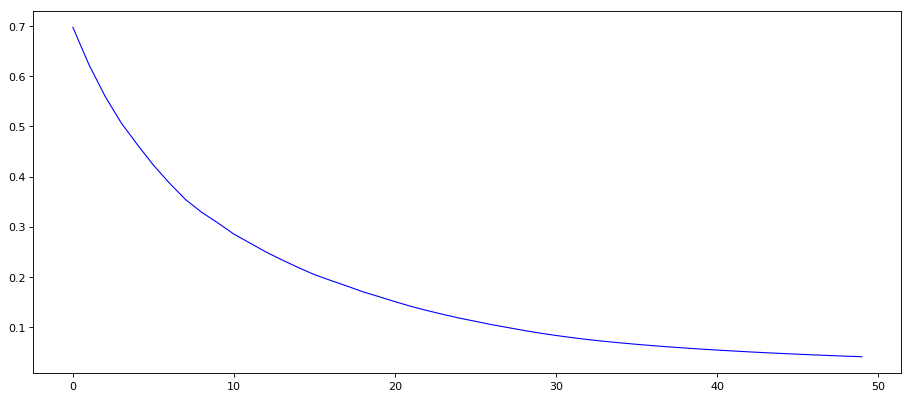

In [55]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(lr.losses)
ax.plot(range(0,size), lr.losses, '-', color='blue', animated = True, linewidth=1)

Now let’s examine whether we are getting good results. Note: best practice is to use a training and a test data set for this which we’ve omitted here for simplicity

In [56]:
score(data_healthy_scaled)

array([[0.94618535],
       [0.9701914 ],
       [0.9701914 ]], dtype=float32)

In [57]:
score(data_broken_scaled)

array([[0.0638805],
       [0.0283131],
       [0.0283131]], dtype=float32)

### Submission

In case you feel confident that everything works as it should (getting values close to one for the healthy and close to zero for the broken case) you can make sure that the secret variable contains a valid submission token and submit your work to the grader


In [58]:
parts_data = {}
parts_data["0dXlH"] = json.dumps({"number_of_neurons_layer1": number_of_neurons_layer1, "number_of_neurons_layer2": number_of_neurons_layer2, "number_of_neurons_layer3": number_of_neurons_layer3, "number_of_epochs": number_of_epochs})
parts_data["O5cR9"] = json.dumps({"dim": dim, "samples": samples})

                                 
                                 
token = "6vemRNPHrQlvWbBo"

In [59]:
prediction = str(np.sum(score(data_healthy_scaled))/3)
myData={'healthy' : prediction}
myData
parts_data["ZzEP8"] = json.dumps(myData)
submitAll(email, token, key, parts_data)

Submission successful, please check on the coursera grader page for the status
-------------------------
{"elements":[{"itemId":"MsJRK","id":"tE4j0qhMEeecqgpT6QjMdA~MsJRK~yx83k9PqEeq7AhLMHNS5rw","courseId":"tE4j0qhMEeecqgpT6QjMdA"}],"paging":{},"linked":{}}
-------------------------
